#### andres-quintero_daria-doncevic_youcheng-zhang

# 2 Red Cards Study

## 2.1 Loading and Cleaning the Data

In [4]:
# import python libraries
import os 
from io import BytesIO
#from zipfile import ZipFile
#import requests
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt       
from sklearn.model_selection import KFold
from scipy.sparse.linalg import lsqr

In [5]:
# retrieve red cards data from url
#url = 'https://osf.io/fv8c3/download'
#r = requests.get(url).content
#file = ZipFile(BytesIO(r))
data = os.path.join('CrowdstormingDataJuly1st.csv') 
df = pd.read_csv(data)

In [6]:
# have a look at the dataframe
df.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


We will now apply some filtering steps to the dataframe. We speculate that a player's build might also play a role, therefore we will calculate the BMI and then drop weight and height. On the contrary we don't think age plays a role, therefore we drop it.
Club and league were also removed because they change frequently for the players and only reflect the time point of data collection but not neccessarily the time point a card was received. We furthermore keep the position, as players in certain positions are more likely to commit fouls and therefore also to receive red cards. We sum the yellowReds and the redCards and then we normalize them per games. We also compute the winning and tie/defeat rate, as teams and players who are winning the game are probably less likely to commit fouls/receive cards than the other way around. Afterwards we can drop games, victories, ties, defeats, yellowCards, yellowReds and redCards. We ignore the yellow cards, as the research question is specifically stating red cards.
For the skin color, we calculate the average rating and then drop rater1 and rater2. 
We will furthermore drop the columns player (keep playerShort), photoID, refCountry (neccessary info is already in the columns meanIAT and meanExp), Alpha_3 (looks like a country, but no info in the README) and nIAT, seIAT, nExp and seExp.

We then filter the dataframe further by removing rows for which we have no information about a player's BMI or skin color. And we remove referees with fewer than 10 appearances.

Below are the step-wise details of the data preprocessing.

In [7]:
# filter the data frame 
# What relevant features might be missing, but can be computed? 
# calculate bmi
# calculate yellow and red cards per game and separately for victories and ties + defeats 
# take the mean of the two raters 
# remove the columns player, club, age, photoID, Alpha_3, nIAT, seIAT, nExp, seExp

df['bmi'] = df['weight']/((df['height']/100)**2)
df['redPerGame'] = (df['yellowReds'] + df['redCards'])/df['games']
df['winningRate'] = (df['victories']/df['games'])
df['losingRate'] = (df['ties'] + df['defeats'])/df['games']
df['skincolor'] = (df['rater1'] + df['rater2'])/2

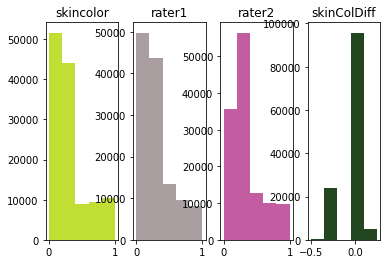

In [8]:
# Are there missing data values?
# To address the issue, simply removal or imputation
# How good are the skin color ratings? Do the raters agree?
# The two raters disagree about player skintone quite often. 
# Besides censoring data in players photos also leads to missing color ratings.
df['skinColDiff'] = df['rater1'] - df['rater2']
ra = df['rater1'] == df['rater2']
ra.value_counts()

var = ['skincolor','rater1','rater2','skinColDiff']
fig, ax = plt.subplots(1,len(var))

for i in range(len(var)):
    ax[i].hist(df[var[i]], bins = 5, color = np.random.rand(3,))
    ax[i].set_title(var[i])

plt.show()

In [ ]:
# Should referees with very few appearances be excluded from the dataset?
# We also calculate the number of appearances of referees and number of referee dyads pair (refCount)
# We deal with this covariates in the several later step.

df['refCount']=0

refs=pd.unique(df['refNum'].values.ravel())
#for each ref, count their dyads

for r in refs:
    df['refCount'][df['refNum']==r]= len(df[df['refNum']==r])  

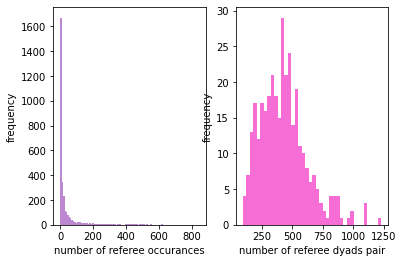

In [10]:
fig, ax = plt.subplots(1,2)
ax[0].hist(df['refNum'].value_counts(), bins = 100, color = np.random.rand(3,))
ax[0].set_xlabel('number of referee occurances')
ax[0].set_ylabel('frequency')
ax[1].hist(df['refCount'].value_counts(),  bins = 40, color = np.random.rand(3,))
ax[1].set_xlabel('number of referee dyads pair')
ax[1].set_ylabel('frequency')
plt.show()

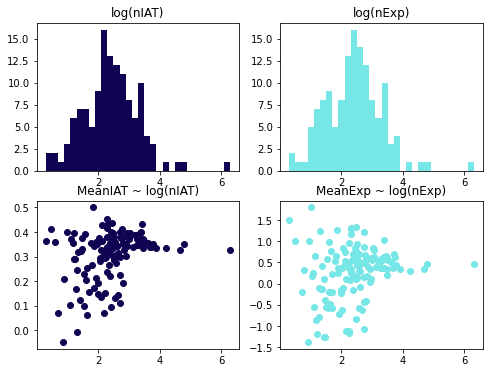

In [11]:
# In addition, we check the IAT and Exp statistics

fig, ax = plt.subplots(2,2, figsize=(8,6))
c1, c2 = np.random.rand(3,), np.random.rand(3,)
ax[0,0].hist( np.log10(df.drop_duplicates(subset=['nIAT'])['nIAT']) ,bins=30 ,color = c1)
ax[0,0].set_title('log(nIAT)')
ax[0,1].hist( np.log10(df.drop_duplicates(subset=['nExp'])['nExp']) ,bins=30 ,color = c2)
ax[0,1].set_title('log(nExp)')
ax[1,0].scatter(np.log10(df.drop_duplicates(subset=['nIAT'])['nIAT']), df.drop_duplicates(subset=['nIAT'])['meanIAT'], color = c1)
ax[1,0].set_title('MeanIAT ~ log(nIAT)')
ax[1,1].scatter(np.log10(df.drop_duplicates(subset=['nExp'])['nExp']), df.drop_duplicates(subset=['nExp'])['meanExp'], color = c2)
ax[1,1].set_title('MeanExp ~ log(nExp)')
plt.show()


In [12]:
df = df.drop(columns=['player','club','leagueCountry','birthday','height','weight','games','victories','ties','defeats', 'goals', 'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2','refCountry', 'Alpha_3', 'nIAT', 'seIAT', 'nExp', 'seExp','skinColDiff','refCount'])

# remove rows with missing values
df = df.dropna(axis=0)

# remove referees that have less or equal to 10 appearances
referees = df['refNum'].value_counts()
good_referees = referees[referees >= 10].index.to_numpy()
df = df.loc[df['refNum'].isin(good_referees)]

# inspect the filtered dataframe
df.head()

,playerShort,position,refNum,meanIAT,meanExp,bmi,redPerGame,winningRate,losingRate,skincolor
5,aaron-hughes,Center Back,4,0.325185,0.538462,21.434609,0.0,0.0,1.0,0.125
6,aleksandar-kolarov,Left Fullback,4,0.325185,0.538462,22.877406,0.0,1.0,0.0,0.125
7,alexander-tettey,Defensive Midfielder,4,0.325185,0.538462,20.987654,0.0,0.0,1.0,1.000
8,anders-lindegaard,Goalkeeper,4,0.325185,0.538462,21.477087,0.0,0.0,1.0,0.250
9,andreas-beck,Right Fullback,4,0.325185,0.538462,21.604938,0.0,1.0,0.0,0.000


In [13]:
# split the data into predictors and response variable
X = df[['skincolor','meanIAT', 'meanExp', 'bmi', 'winningRate','position']]
X.head()


,skincolor,meanIAT,meanExp,bmi,winningRate,position
5,0.125,0.325185,0.538462,21.434609,0.0,Center Back
6,0.125,0.325185,0.538462,22.877406,1.0,Left Fullback
7,1.000,0.325185,0.538462,20.987654,0.0,Defensive Midfielder
8,0.250,0.325185,0.538462,21.477087,0.0,Goalkeeper
9,0.000,0.325185,0.538462,21.604938,1.0,Right Fullback


In [14]:
# one-hot encoding of categorical vars
X = pd.concat([X, pd.get_dummies(X.position)], axis=1)
X = X.drop(columns = ['position']).to_numpy()
y = df['redPerGame'].values

In [15]:
# Should features be normalized and/or centralized?
# Yes. We performed centering on the data. 

data = X - np.mean(X, axis = 0)[None, :]
red_cards_frac = y - np.mean(y)
data.shape

(110462, 17)

In [16]:
red_cards_frac.shape

(110462,)

## 2.2 Model Creation

### Regression forests


At first we will implement a random forest regression model by reusing our decision forest model from the last exercise with a few modifications.

In [17]:
# base classes
class Node:
    pass

class Tree:
    def __init__(self):
        self.root = Node()
    
    def find_leaf(self, x):
        node = self.root
        while hasattr(node, "feature"):
            j = node.feature
            if x[j] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node
    
# Regression tree class    
class RegressionTree(Tree):
    def __init__(self):
        super(RegressionTree, self).__init__()
        
    def train(self, data, labels, n_min=20):
        '''
        data: the feature matrix for all digits
        labels: the corresponding ground-truth responses
        n_min: termination criterion (don't split if a node contains fewer instances)
        '''
        N, D = data.shape
        D_try = int(np.sqrt(D)) # how many features to consider for each split decision

        # initialize the root node
        self.root.data = data
        self.root.labels = labels
        
        stack = [self.root]
        while len(stack):
            node = stack.pop()
            n = node.data.shape[0] # number of instances in present node
            if n >= n_min:
                # Call 'make_decision_split_node()' with 'D_try' randomly selected 
                # feature indices. This turns 'node' into a split node
                # and returns the two children, which must be placed on the 'stack'.
                
                # If feature min and max is the same, it has to be excluded
                valid_features = np.where(np.min(node.data, axis=0) != np.max(node.data, axis=0))[0]
                
                if len(valid_features) > 0:
                    # 'D_try' randomly selected indices from 'valid_features'
                    idx = np.random.permutation(valid_features)[:D_try]
                    # Place node's children on the 'stack'
                    left, right = make_regression_split_node(node=node, feature_indices=idx)
                    stack.extend([left, right])
                else:
                    #if there are no valid features turn node to leaf
                    make_regression_leaf_node(node)
            else:
                make_regression_leaf_node(node)

                
    def predict(self, x):
        leaf = self.find_leaf(x)
        # response is the average response of instaces in leaf
        return leaf.response
    
    

def node_sqerr_over_tj(mask, labels):
    '''
    mask: boolean array, indicating wich instances belong to the node
          its dimension is number of instances in parent node x number of tj
    labels: labels of parent node
    '''
    N = np.sum(mask, axis = 0)
    C = np.max(labels) + 1
    
    # Multiply labels by the mask, to keep only labels in node
    # others will be 0
    labels_mask = labels[:, None] * mask
    # Estimate average response
    yhat_node = np.sum(labels_mask, axis = 0)/np.sum(mask, axis = 0)
    
    # Squared error
    # multiply my mask to set members of other node to 0
    sqerr = np.sum(np.square(labels[:, None] - yhat_node[None, :]) * mask, axis=0)
    # return the Squared error
    return sqerr
    
    
def make_regression_split_node(node, feature_indices):
    '''
    node: the node to be split
    feature_indices: a numpy array of length 'D_try', containing the feature 
                     indices to be considered in the present split
    '''
    n, D = node.data.shape

    # find best feature j (among 'feature_indices') and best threshold t for the split
    e_min = float("inf")
    j_min, t_min = None, None
    
    for j in feature_indices:
        data_unique = np.unique(node.data[:, j])
        # Compute candidate thresholds
        tj = (data_unique[1:]+data_unique[0:-1])/2
        #print(tj)
        # First make a mask of instances for all thresholds
        mask_tj = node.data[:, None, j] < tj[None, :]
        # Compute Gini impurity scores for left and right children
        sqerr_l = node_sqerr_over_tj(mask=mask_tj, labels=node.labels)
        sqerr_r = node_sqerr_over_tj(mask=np.invert(mask_tj), labels=node.labels)
        sqerr_tj = sqerr_l + sqerr_r 
               
        # Find best split for the current feature j
        bestt_idx = np.argmin(sqerr_tj)
        sqerr = sqerr_tj[bestt_idx]
        
        # choose the best threshold that
        if sqerr < e_min:
            e_min = sqerr
            j_min = j
            t_min = tj[bestt_idx]
            # Save mask of best split
            mask_min = mask_tj[:, bestt_idx].copy()
    
    if e_min == float("inf"):
        print(feature_indices)
        print(e_min)
    # create children
    left = Node()
    right = Node()
    
    # initialize 'left' and 'right' with the data subsets and labels
    # according to the optimal split found above
    left.data    = node.data[mask_min, ] # data in left node
    left.labels  = node.labels[mask_min].copy() # corresponding labels
    right.data   = node.data[np.invert(mask_min), ]
    right.labels = node.labels[np.invert(mask_min)].copy()
    
    # turn the current 'node' into a split node
    # (store children and split condition)
    node.left = left
    node.right = right
    node.feature = j_min
    node.threshold = t_min
    node.data = None

    # return the children (to be placed on the stack)
    return left, right    

def make_regression_leaf_node(node):
    '''
    node: the node to become a leaf
    '''
    # compute and store leaf response
    #node.N = len(node.data)
    node.response = np.mean(node.labels)
    
regTree = RegressionTree()
regTree.train(data=data[0:1000,0:25], labels=red_cards_frac[0:1000],  n_min=2)
#regTree.train(data=data, labels=red_cards_frac,  n_min=20)
#regTree.predict(x=data[165,:])


In [15]:
class RegressionForest():
    def __init__(self, n_trees):
        # create ensemble
        self.trees = [RegressionTree() for i in range(n_trees)]
    
    def train(self, data, labels, n_min=0):
        for tree in self.trees:
            # train each tree, using a bootstrap sample of the data
            N = len(data)
            idx = np.random.choice(N, size=N, replace=True)
            data_p   = data[idx, :]
            labels_p = labels[idx]
            tree.train(data=data_p, labels=labels_p, n_min=n_min)

    def predict(self, x):
        # compute the ensemble prediction
        return(np.mean([tree.predict(x) for tree in self.trees]))
    
regForest = RegressionForest(n_trees=10)
regForest.train(data=data[0:1000,0:25], labels=red_cards_frac[0:1000],  n_min=0)
#regForest.train(data=data[:,0:25], labels=red_cards_frac,  n_min=0)
#regForest.train(data=data, labels=red_cards_frac,  n_min=20)
print(red_cards_frac[165])
regForest.predict(x=data[165,:])



-0.008209157374052508


-0.008209157374052508

In [18]:
from sklearn.model_selection import KFold

#data = data[0:1000,0:25]
#red_cards_frac = red_cards_frac[0:1000]

def crossVal_RegressionForest(n_splits, n_trees, n_min, data, y):
    kf = KFold(n_splits=n_splits)
    regForest_sqerr = []

    for train, test in kf.split(data):
        X_train_kf = data[train,]
        X_test_kf  = data[test,]
        y_train_kf = y[train,]
        y_test_kf  = y[test,]
        #print("%s %s" % (train, test))
        regForest = RegressionForest(n_trees=n_trees)
        regForest.train(data=X_train_kf, labels=y_train_kf,  n_min=n_min)
        regForest_pred = [regForest.predict(x=X_test_kf[i,:]) for i in range(len(X_test_kf))]
        regForest_sqerr.append(np.mean(np.square(y_test_kf - regForest_pred)))    
    return(np.array(regForest_sqerr))


ßregForest_sqerr = crossVal_RegressionForest(n_splits=10, n_trees=20, n_min=100, data=data, y=red_cards_frac)
#filename = "regForest_sqerr_CV.pkl"
#pickle.dump(regForest_sqerr, open(filename, 'wb'))



In [23]:
regForest_sqerr = pickle.load(open("regForest_sqerr_CV.pkl",'rb'))

print('The squared test error of the regression trees after 10fold cross validation is:')
print('Test error: %0.4f (+/- %0.4f)' % (regForest_sqerr.mean(), regForest_sqerr.std() * 2))

The squared test error of the regression trees after 10fold cross validation is:
Test error: 0.0052 (+/- 0.0011)


## Linear regression

In [24]:
#np.linalg.lstsq(a, b, rcond='warn')[source]

class LinearRegression():    
    def train(self, data, labels):
        self.beta, _, _, _ = np.linalg.lstsq(data, labels, rcond=None)

    def predict(self, x):
        return(np.dot(x, self.beta.T))
        #return(np.sum(x * self.beta))
    
    
    
linearReg = LinearRegression()
linearReg.train(data, red_cards_frac)
linearReg.predict(data[0:5,:])

array([ 0.00502127, -0.00356833,  0.00463967, -0.00216702, -0.00405181])

In [25]:
#data = data[:,0:25]

def crossVal_LinearRegression(n_splits, data, y):
    kf = KFold(n_splits=n_splits)
    linearReg_sqerr = []

    for train, test in kf.split(data):
        X_train_kf = data[train,]
        X_test_kf  = data[test,]
        y_train_kf = y[train,]
        y_test_kf  = y[test,]
        #print("%s %s" % (train, test))
        linearReg = LinearRegression()
        linearReg.train(X_train_kf, y_train_kf)
        linearReg_pred = linearReg.predict(X_test_kf)
        linearReg_sqerr.append(np.mean(np.square(y_test_kf - linearReg_pred)))
    
    return(np.array(linearReg_sqerr))


#linearReg_sqerr = crossVal_LinearRegression(n_splits=10, data=data, y=red_cards_frac)
#filename = "regLinear_sqerr_CV.pkl"
#pickle.dump(linearReg_sqerr, open(filename, 'wb'))


In [26]:
linearReg_sqerr = pickle.load(open("regLinear_sqerr_CV.pkl",'rb'))

print('The squared test error of the linear regression after 10fold cross validation is:')
print('Test error: %0.4f (+/- %0.4f)' % (linearReg_sqerr.mean(), linearReg_sqerr.std() * 2))

The squared test error of the linear regression after 10fold cross validation is:
Test error: 0.0051 (+/- 0.0011)


## 2.3 Answering the Research Question

### Permutation study with Linear regression model

In [34]:
#print(data[0,0:5])
#np.random.permutation(data[0,0:5])

def permutationLR_skincolor(n_permutations, n_splits, data, y):
    data_per = data.copy()
    sqerr = []
    for p in range(n_permutations):
        data_per[:,0] = np.random.permutation(data[:,0])
        sqerr.append(crossVal_LinearRegression(n_splits=n_splits, data=data_per, y=y).mean())
    
    return(np.array(sqerr))

sqLR_PT = permutationLR_skincolor(n_permutations=19, n_splits=10, data=data, y=red_cards_frac)

filename = "regLinear_sqerr_PT.pkl"
pickle.dump(sqLR_PT, open(filename, 'wb'))

#linearReg_sqerr.mean() - permutationLR_skincolor(n_permutations=19, n_splits=10, data=data, y=red_cards_frac)

In [35]:
sqLR_PT = pickle.load(open("regLinear_sqerr_PT.pkl",'rb'))

# Compared the original prediction with the permutated prediction
linearReg_sqerr.mean() - sqLR_PT


array([-0.01013252, -0.01007037, -0.00952573, -0.01063545, -0.00982821,
       -0.0100167 , -0.01015196, -0.01025618, -0.00981732, -0.0108182 ,
       -0.01002757, -0.00998884, -0.00988621, -0.01022883, -0.00997411,
       -0.01057687, -0.00983478, -0.00974217, -0.0100604 ])

In [ ]:
# We can observe from the result above that 
# all the error obtained in the permutation studies have higher
# mean error rate than the original prediction, which 
# indicates that there is a skin color bias in red card decisions 
# with a p-value of p = 1/20 = 0.05.

### Permutation study with Regression Forest model

In [27]:
#print(data[0,0:5])
#np.random.permutation(data[0,0:5])

def permutationRF_skincolor(n_permutations, n_splits, data, y):
    data_per = data.copy()
    sqerr = []
    for p in range(n_permutations):
        data_per[:,0] = np.random.permutation(data[:,0])
        sqerr.append(crossVal_RegressionForest(n_splits=10, n_trees=20, n_min=100, data=data, y=y).mean())
    
    return(np.array(sqerr))

#sqRF_PT = permutationRF_skincolor(n_permutations=19, n_splits=10, data=data, y=red_cards_frac)
#filename = "regForest_sqerr_PT.pkl"
#pickle.dump(sqRF_PT, open(filename, 'wb'))

#regForest_sqerr.mean() - permutationRF_skincolor(n_permutations=19, n_splits=10, data=data, y=red_cards_frac)


In [28]:
sqRF_PT = pickle.load(open("regForest_sqerr_PT.pkl",'rb'))

# Compared the original prediction with the permutated prediction
regForest_sqerr.mean() - sqRF_PT


array([ 3.35925607e-06,  6.90559170e-06,  2.28863121e-06,  4.97973556e-06,
        7.59696700e-06, -9.71007931e-07,  5.55382046e-06,  5.63348454e-06,
        7.75422060e-07,  4.82128769e-06,  1.53809572e-06,  4.61566626e-06,
        5.27233021e-06, -2.69285351e-06,  4.20177620e-06,  5.78407956e-06,
       -2.59548012e-06,  9.02353073e-06,  8.10400460e-06])

## 2.4 How to lie with statistics

In [161]:
# We re-preprocess the covariate 'position' in our dataset.
# For example, here we use a new, but equally plausible cleaned 
# dataset by excluding several positions.
# And rerun the model and the permutation test.
data_lie = data[:,0:12]
red_cards_frac_lie = red_cards_frac
data_lie.shape

(110462, 12)

In [158]:
# First we re-run the CV with linear regression model

linearReg_sqerr_lie = crossVal_LinearRegression(n_splits=10, data=data_lie, y=red_cards_frac_lie)

print('The squared test error of the linear regression after 10fold cross validation is:')
print('Test error: %0.8f (+/- %0.8f)' % (linearReg_sqerr_lie.mean(), linearReg_sqerr_lie.std() * 2))


The squared test error of the linear regression after 10fold cross validation is:
Test error: 0.00507196 (+/- 0.00108319)


In [159]:
# Then we re-run the permutation test with linear regression model
sqLR_PT_lie = permutationLR_skincolor(n_permutations=19, n_splits=10, data=data_lie, y=red_cards_frac_lie)
sqLR_PT_lie

array([0.00507205, 0.00507222, 0.00507202, 0.00507221, 0.00507217,
       0.00507219, 0.00507222, 0.00507216, 0.00507185, 0.00507217,
       0.0050718 , 0.00507223, 0.00507211, 0.00507218, 0.00507222,
       0.00507218, 0.00507223, 0.00507216, 0.00507239])

In [160]:
# Compared the original prediction with the permutated prediction
# We can observe that after removing some of the positions in the data, 
# this time not all permutated datasets exhibit higher test errors than 
# the original unscattered dataset. 
# Therefore, we cannot conclude the skin color bias with this different preprocessed dataset.

linearReg_sqerr_lie.mean() - sqLR_PT_lie

array([-9.72730139e-08, -2.68674466e-07, -6.56443452e-08, -2.55833351e-07,
       -2.16248313e-07, -2.30814547e-07, -2.66748468e-07, -2.07675057e-07,
        1.04299162e-07, -2.09525478e-07,  1.59694460e-07, -2.71167498e-07,
       -1.54846042e-07, -2.28616035e-07, -2.63327293e-07, -2.21968126e-07,
       -2.74670989e-07, -2.09098416e-07, -4.29633952e-07])

## 2.4 How to lie with statistics ( other solution )

In [148]:
# filter the data frame 
# calculate bmi
# calculate yellow and red cards per game and separately for victories and ties + defeats 
# take the mean of the two raters 
# remove the columns player, club, age, photoID, Alpha_3, nIAT, seIAT, nExp, seExp
# Import original data
df = pd.read_csv('data/CrowdstormingDataJuly1st.csv')


df['bmi'] = df['weight']/((df['height']/100)**2)
df['redPerGame'] = (df['yellowReds'] + df['redCards'])/df['games']
df['winningRate'] = (df['victories']/df['games'])
#df['losingRate'] = (df['ties'] + df['defeats'])/df['games']
#df['skincolor'] = (df['rater1'] + df['rater2'])/2
df.insert(loc=0, column='skintone', value=(df['rater1']+df['rater2'])/2)
df = df.drop(columns=['player','club','leagueCountry','birthday','height','weight','games','victories','ties','defeats', 'goals', 'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2','refCountry', 'Alpha_3', 'nIAT', 'seIAT', 'nExp', 'seExp'])

# remove rows with missing values
df = df.dropna(axis=0)

# remove referees that have less or equal to 10 appearances
referees = df['refNum'].value_counts()
good_referees = referees[referees >= 10].index.to_numpy()
df = df.loc[df['refNum'].isin(good_referees)]

# inspect the filtered dataframe
df.head()

,skintone,playerShort,position,refNum,meanIAT,meanExp,bmi,redPerGame,winningRate
5,0.125,aaron-hughes,Center Back,4,0.325185,0.538462,21.434609,0.0,0.0
6,0.125,aleksandar-kolarov,Left Fullback,4,0.325185,0.538462,22.877406,0.0,1.0
7,1.000,alexander-tettey,Defensive Midfielder,4,0.325185,0.538462,20.987654,0.0,0.0
8,0.250,anders-lindegaard,Goalkeeper,4,0.325185,0.538462,21.477087,0.0,0.0
9,0.000,andreas-beck,Right Fullback,4,0.325185,0.538462,21.604938,0.0,1.0


In [151]:
# split the data into predictors and response variable
df_fil = col_to_onehot(df, 'position')

# Remove non longer used features
#df_fil = df_fil.drop(['yellowReds', 'redCards', 'birthday', 'rater1', 'rater2'],axis = 1)
#df_fil


#red_cards = df_fil['allreds'].values
#data = df_fil.drop(['allreds'],axis = 1).values

red_cards_frac = (df_fil['redPerGame']).values
data = df_fil.drop(['redPerGame', 'refNum', 'playerShort'],axis = 1).values

#data = (data - np.min(data, axis = 0))/np.max(data, axis = 0)
data = data - np.mean(data, axis = 0)[None, :]
red_cards_frac = red_cards_frac - np.mean(red_cards_frac)
data.shape


(110462, 17)

In [152]:
linearReg_sqerr_lie = crossVal_LinearRegression(n_splits=10, data=data, y=red_cards_frac)
linearReg_sqerr_lie.mean() - permutation_skincolor(n_permutations=19, n_splits=10, 
                                                   data=data, y=red_cards_frac)

array([-3.36768036e-07, -2.45166605e-08, -2.14562263e-07, -1.60399593e-07,
       -3.25754918e-07, -2.42182250e-07, -2.84315240e-07, -2.77963651e-07,
       -2.94460698e-07, -2.12486841e-07, -1.97019917e-07, -2.75422977e-07,
       -2.82708669e-07, -2.28413226e-07, -2.52279742e-07, -2.46720212e-07,
       -8.31350852e-08, -3.19418121e-07, -2.63563303e-07])

In [260]:
df = pd.read_csv('data/CrowdstormingDataJuly1st.csv')


df['bmi'] = df['weight']/((df['height']/100)**2)
df['redPerGame'] = (df['yellowReds'] + df['redCards'])/df['games']
df['winningRate'] = (df['victories']/df['games'])
#df['losingRate'] = (df['ties'] + df['defeats'])/df['games']
#df['skincolor'] = (df['rater1'] + df['rater2'])/2
df.insert(loc=0, column='skintone', value=(df['rater1']+df['rater2'])/2)
df = df.drop(columns=['player','club','leagueCountry','birthday','height','weight','games','victories','ties','defeats', 'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2','refCountry', 'Alpha_3', 'nIAT', 'seIAT', 'nExp', 'seExp'])

# remove rows with missing values
df = df.dropna(axis=0)

# remove referees that have less or equal to 10 appearances
referees = df['refNum'].value_counts()
good_referees = referees[referees >= 10].index.to_numpy()
df = df.loc[df['refNum'].isin(good_referees)]


# split the data into predictors and response variable
#df_fil = col_to_onehot(df, 'position')
#df_fil = col_to_onehot(df_fil, 'playerShort')
df_fil = df
#df_fil = col_to_onehot(df_fil, 'refNum')

# Remove non longer used features
#df_fil = df_fil.drop(['yellowReds', 'redCards', 'birthday', 'rater1', 'rater2'],axis = 1)
#print(df_fil)


#red_cards = df_fil['allreds'].values
#data = df_fil.drop(['allreds'],axis = 1).values

#df_fil = df_fil[df_fil['bmi'] >= 25.5]
df_fil = df_fil[df_fil['goals'] > 0]



red_cards_frac_lie = (df_fil['redPerGame']).values
data_lie = df_fil.drop(['refNum', 
                        #'skintone',
                        #"bmi",
                        'position',
                        'meanIAT', 
                        'meanExp',
                        'playerShort',
                       'redPerGame',],axis = 1).values

#data = (data - np.min(data, axis = 0))/np.max(data, axis = 0)
data_lie = data_lie - np.mean(data_lie, axis = 0)[None, :]
red_cards_frac_lie = red_cards_frac_lie - np.mean(red_cards_frac_lie)
data_lie.shape



(23659, 4)

In [261]:
linearReg_sqerr_lie = crossVal_LinearRegression(n_splits=10, data=data_lie, y=red_cards_frac_lie)
linearReg_sqerr_lie.mean() - permutation_skincolor(n_permutations=19, n_splits=10, 
                                                   data=data_lie, y=red_cards_frac_lie)

array([-4.52804725e-07, -4.84823235e-07, -4.47617963e-07, -3.84049446e-07,
       -4.87740082e-07, -5.01143763e-07, -3.68492098e-07, -5.26417849e-07,
       -4.42314541e-07, -4.32992624e-07, -5.73170030e-07, -1.20965980e-07,
       -4.10098470e-07, -4.49495334e-07, -3.70664350e-07, -7.81388552e-07,
       -4.26896763e-07, -4.17210196e-07, -3.00707356e-07])

In [168]:
df_fil

,skintone,playerShort,position,refNum,meanIAT,meanExp,bmi,redPerGame,winningRate
5,0.125,aaron-hughes,Center Back,4,0.325185,0.538462,21.434609,0.0,0.0
6,0.125,aleksandar-kolarov,Left Fullback,4,0.325185,0.538462,22.877406,0.0,1.0
7,1.000,alexander-tettey,Defensive Midfielder,4,0.325185,0.538462,20.987654,0.0,0.0
8,0.250,anders-lindegaard,Goalkeeper,4,0.325185,0.538462,21.477087,0.0,0.0
9,0.000,andreas-beck,Right Fullback,4,0.325185,0.538462,21.604938,0.0,1.0
...,...,...,...,...,...,...,...,...,...
146022,0.500,tom-huddlestone,Defensive Midfielder,3147,0.376127,0.498350,22.634676,0.0,0.0
146023,0.000,tomas-rosicky,Attacking Midfielder,3147,0.376127,0.498350,21.146320,0.0,1.0
146024,0.375,winston-reid,Center Back,3147,0.376127,0.498350,24.099723,0.0,0.0
146025,0.250,xherdan-shaqiri,Left Midfielder,3147,0.376127,0.498350,25.209201,0.0,1.0


In [204]:
def permutationForest_skincolor(n_permutations, n_splits, n_trees, n_min, data, y):
    data_per = data.copy()
    sqerr = []
    for p in range(n_permutations):
        data_per[:,0] = np.random.permutation(data[:,0])
        sqerr.append(crossVal_RegressionForest(n_splits=10, n_trees=n_trees, n_min=n_min, data=data_per, y=y).mean())
    
    return(np.array(sqerr))


regForest_sqerr_lie = crossVal_RegressionForest(n_splits=10, n_trees=10, n_min=100, data=data_lie, y=red_cards_frac_lie)

regForest_sqerr_lie.mean() - permutationForest_skincolor(n_permutations=19, n_splits=10, n_trees=10, 
                                                     n_min=100, data=data_lie, y=red_cards_frac_lie)

array([8.15331161e-05, 9.06359012e-05, 9.84969434e-05, 8.48110551e-05,
       3.95936038e-05, 5.74497862e-05, 1.00094019e-04, 9.87227894e-06,
       5.50688275e-05, 8.62790689e-05, 1.67112729e-04, 4.37248669e-05,
       3.47577702e-05, 1.74511260e-05, 6.21804213e-05, 6.03543653e-05,
       9.43389270e-05, 9.61925690e-05, 6.07316503e-05])

## 2.5 Alternative hypotheses

These leads us to generating an alternative hypothesis.
Hypothesis: Some positions are more likely to receive red cards and players with darker skin are overrepresented in these positions.

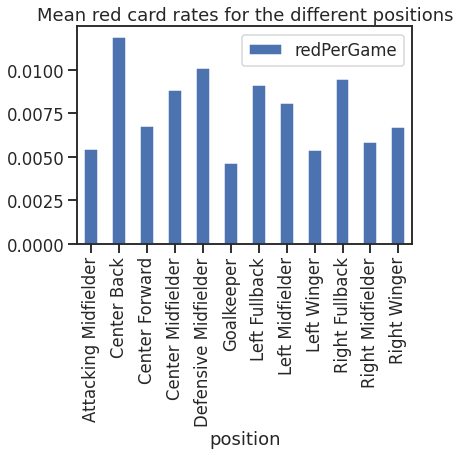

In [42]:
# compute the mean rate of red cards per game for each position
position_cards = df[['position', 'redPerGame']].groupby('position').mean()
position_cards.plot.bar(y='redPerGame')
plt.title("Mean red card rates for the different positions");

From this plot we can see that there are indeed differences for the red card rates based on the position. This also agrees with our intuition that the goal keeper for example has the lowest red card rate. The Center Back has the highest red card rate among all positions.

Now we want to investigate if there is a bias between skin color and position.

In [ ]:
# divide players into dark (skin color >= 0.5) and light (skin color < 0.5) and calculate how often they play certain positions
df['Skincolor'] = np.where(df['skincolor'] >= 0.5, 'Dark', 'Light')
sk_pos = df[['Skincolor', 'position']].groupby(['Skincolor', 'position']).size().to_frame('percentage')
sk_pos = (sk_pos / sk_pos.groupby(level=0).sum()).reset_index()
sk_pos = pd.DataFrame({'position': sk_pos.loc[sk_pos['Skincolor'] == 'Dark', 'position'].tolist(),
                       'Dark': sk_pos.loc[sk_pos['Skincolor'] == 'Dark', 'percentage'].tolist(),
                       'Light': sk_pos.loc[sk_pos['Skincolor'] == 'Light', 'percentage'].tolist() })

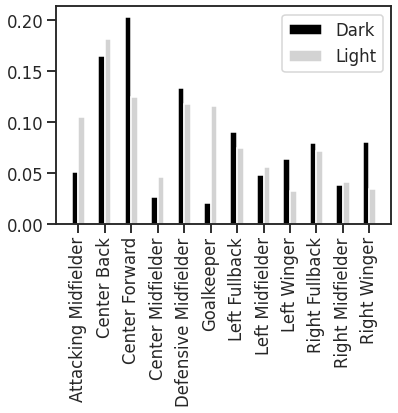

In [75]:
# plot what percentage of dark/light players plays in a certain position
plt.figure()
x = np.arange(len(sk_pos))
plt.bar(x,sk_pos['Dark'],width=0.25,label='Dark',color = 'black')
plt.bar(x + 0.25,sk_pos['Light'],width=0.25,label='Light',color = 'lightgrey')
plt.xticks(x + 0.25 / 2, sk_pos['position'],rotation=90)
plt.legend()
plt.show()

From this plot we can see that especially for the position of goal keeper, which receives the least red cards, players with darker color are underrepresented. Also for the position of Attacking Midfielder, which has the second lowest red card rate, there is a higher percentage among players with lighter color.